# Robótica Móvel - Trabalho Prático 1 (Exercícios 5-6)
---
**Nome Completo:** Daniel Terra Gomes

**Matrícula:** 2025702870 

**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br

**Data:** 11 de setembro de 2025

---

Este notebook implementa os exercícios 5-6 do TP1, focando em:
- Integração de sensores laser (Hokuyo)
- Transformação de dados de sensores para frame global
- Navegação autônoma básica
- Mapeamento incremental com dados de laser

**Atenção:** Use a cena `T1-ex5-6.ttt` que contém o robô Pioneer P3DX com sensor laser.

In [1]:
# Imports necessários
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy

# Import das utils criadas para o TP1
from robotics_utils import (
    CoppeliaSimConnector,
    SceneAnalyzer,
    wait_for_user_input,
    validate_transformation_matrix,
    HokuyoSensorSim,
    draw_laser_data,
    create_homogeneous_matrix,
    invert_homogeneous_matrix
)

# === Configuration and Constants ===

#TODO: modify ex3 code: the robot and add its laser sensor /PioneerP3DX/fastHokuyo
# Default object mapping for TP1 scenes
#TODO: DEBUG: FOUND! The Pillars were killing the env.
DEFAULT_OBJECT_MAPPING_EX5_6 = {
    'Robot': 'PioneerP3DX',
    'Bill_0': 'Bill[0]',
    'Bill_1': 'Bill[1]',
    'Crate': 'Floor/ConcretBlock',
    'SwivelChair': 'swivelChair',
    'Plant': 'indoorPlant',
    'Hokuyo': 'PioneerP3DX/fastHokuyo',
    'Table': 'diningTable',
    'Laptop_0': 'diningTable/laptop[0]',
    'Laptop_1': 'diningTable/laptop[1]',
    'Fence_0': '80cmHighWall100cm[0]',
    'Fence_1': '80cmHighWall100cm[1]'
}

print("Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.")

Certifique-se de que o CoppeliaSim está rodando com a cena T1.ttt aberta.


In [2]:
# Conectar ao CoppeliaSim
print("Conectando ao CoppeliaSim...")
connector = CoppeliaSimConnector()

if not connector.connect():
    raise RuntimeError("Falha na conexão com CoppeliaSim. Verifique se o simulador está rodando.")

# Descobrir objetos na cena
object_handles = connector.discover_objects(DEFAULT_OBJECT_MAPPING_EX5_6)

if not object_handles:
    raise RuntimeError("Nenhum objeto encontrado. Verifique se a cena T1.ttt está carregada.")

print(f"\nObjetos descobertos: {list(object_handles.keys())}")

Conectando ao CoppeliaSim...
Successfully connected to CoppeliaSim
Discovered 12 objects:
  Robot: Handle 109
  Bill_0: Handle 31
  Bill_1: Handle 76
  Crate: Handle 25
  SwivelChair: Handle 160
  Plant: Handle 162
  Hokuyo: Handle 153
  Table: Handle 64
  Laptop_0: Handle 68
  Laptop_1: Handle 72
  Fence_0: Handle 166
  Fence_1: Handle 168

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'SwivelChair', 'Plant', 'Hokuyo', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']
Discovered 12 objects:
  Robot: Handle 109
  Bill_0: Handle 31
  Bill_1: Handle 76
  Crate: Handle 25
  SwivelChair: Handle 160
  Plant: Handle 162
  Hokuyo: Handle 153
  Table: Handle 64
  Laptop_0: Handle 68
  Laptop_1: Handle 72
  Fence_0: Handle 166
  Fence_1: Handle 168

Objetos descobertos: ['Robot', 'Bill_0', 'Bill_1', 'Crate', 'SwivelChair', 'Plant', 'Hokuyo', 'Table', 'Laptop_0', 'Laptop_1', 'Fence_0', 'Fence_1']


### Cenário Inicial: Posição Inicial

**Importante:** O cenário foi modificado em relação aos exercícios anteriores devido a problemas causados pelos pilares originais. Os pilares estavam gerando erros de "chasing" (perseguição) no sistema de navegação, causando comportamentos instáveis no robô.

#### Alterações Realizadas:

1. **Remoção dos Pilares Problemáticos:** Os pilares que causavam erros de navegação foram removidos do cenário
2. **Adição de Novos Elementos:** Foram incluídos novos objetos para criar um ambiente mais adequado para os testes:
  - Cadeiras;
  - Plantas;
  - Paredes...
3. **Paredes Mais Altas:** As paredes foram modificadas para uma altura maior para que o sensor laser possa detectá-las adequadamente
4. **Mapeamento de Objetos Atualizado:** O dicionário `DEFAULT_OBJECT_MAPPING_EX5_6` foi atualizado para refletir os novos elementos do cenário


![Posição Init](Screenshot-inicial_EX5_6.png)

*Figura: mostrando a posição mencionada. Note: o cenario foi modificado devido a error com os pilares presente nos ex1-4*

## Exercício 5: Transformação de Dados do Laser para o Referencial Global

Neste exercício, vamos modificar o script original para transformar os dados do laser do seu referencial local para o referencial global do mundo. Para isso, precisamos definir as matrizes de transformação:

1. $^R _LT$ (laser → robô): Transforma pontos do referencial do laser para o referencial do robô
2. $^W _RT$ (robô → mundo): Transforma pontos do referencial do robô para o referencial global

A transformação completa será: $^W _LT = {^W _RT} \cdot {^R _LT}$

Isso permitirá que visualizemos os pontos detectados pelo laser no referencial global, independentemente da posição atual do robô.

Iniciando testes básicos...
Iniciando simulação...
Configurando o sensor laser Hokuyo...
Fazendo uma leitura do laser...
Número de pontos detectados: 684

Testando movimento básico do robô...
Posição final do robô: [2.153, -2.128, 0.139]

Visualizando dados do laser...


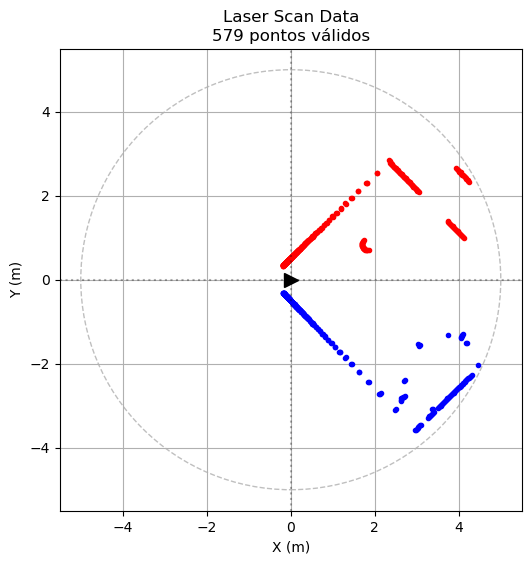


Parando a simulação...
Testes concluídos.


In [3]:
# Teste básico de conexão e funcionamento do sensor laser
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print('Iniciando testes básicos...')

try:
    # Conectar ao CoppeliaSim
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Obter handles do robô e das rodas
    robotname = 'PioneerP3DX'
    robotHandle = sim.getObject('/' + robotname)
    l_wheel = sim.getObject('/' + robotname + '/leftMotor')
    r_wheel = sim.getObject('/' + robotname + '/rightMotor')

    # Parar simulação anterior se necessário
    if sim.getSimulationState() != sim.simulation_stopped:
        print("Parando simulação anterior...")
        sim.stopSimulation()
        time.sleep(1)

    # Iniciar a simulação
    print("Iniciando simulação...")
    sim.startSimulation()
    sim.step()

    # Configurar e testar o sensor Hokuyo
    print("Configurando o sensor laser Hokuyo...")
    hokuyo_sensor = HokuyoSensorSim(sim, f"/{robotname}/fastHokuyo")

    # Obter uma leitura do sensor
    print("Fazendo uma leitura do laser...")
    initial_laser_data = hokuyo_sensor.getSensorData()
    print(f"Número de pontos detectados: {len(initial_laser_data)}")

    # Teste de movimento básico do robô
    print("\nTestando movimento básico do robô...")

    # Parâmetros do Pioneer P3DX
    L = 0.381  # Distância entre rodas (m)
    r = 0.0975 # Raio das rodas (m)

    # Movimento para frente
    v = 0.2  # Velocidade linear (m/s)
    w = 0.0  # Velocidade angular (rad/s)

    # Calcular velocidades das rodas
    wl = v / r - (w * L) / (2 * r)
    wr = v / r + (w * L) / (2 * r)

    # Aplicar velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)

    # Executar alguns passos
    for _ in range(10):
        sim.step()
        time.sleep(0.1)

    # Parar o robô
    sim.setJointTargetVelocity(l_wheel, 0)
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.step()

    # Obter posição final
    pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
    print(f"Posição final do robô: [{pos_final[0]:.3f}, {pos_final[1]:.3f}, {pos_final[2]:.3f}]")

    # Visualizar os dados do laser
    print("\nVisualizando dados do laser...")
    final_laser_data = hokuyo_sensor.getSensorData()
    draw_laser_data(final_laser_data)

except Exception as e:
    print(f"Erro durante os testes: {e}")

finally:
    # Parar a simulação
    print("\nParando a simulação...")
    sim.stopSimulation()
    print('Testes concluídos.')

In [4]:
def transform_laser_data_to_global_frame(sim, laser_data, robot_handle, hokuyo_handle):
    """
    Transforma os dados do laser do referencial local para o referencial global.

    Args:
        sim: O objeto de simulação do CoppeliaSim
        laser_data: Dados do laser no formato [angle, distance]
        robot_handle: Handle do robô
        hokuyo_handle: Handle do sensor Hokuyo

    Returns:
        np.ndarray: Pontos transformados no referencial global [x, y, z]
    """
    # Obter pose do laser em relação ao robô
    laser_pos_robot = sim.getObjectPosition(hokuyo_handle, robot_handle)
    laser_orient_robot = sim.getObjectOrientation(hokuyo_handle, robot_handle)

    # Criar matriz de transformação do laser para o robô (R_T_L)
    R_T_L = create_homogeneous_matrix(
        np.array(laser_pos_robot),
        np.array(laser_orient_robot)
    )

    # Obter pose do robô no referencial global
    robot_pos_world = sim.getObjectPosition(robot_handle, sim.handle_world)
    robot_orient_world = sim.getObjectOrientation(robot_handle, sim.handle_world)

    # Criar matriz de transformação do robô para o mundo (W_T_R)
    W_T_R = create_homogeneous_matrix(
        np.array(robot_pos_world),
        np.array(robot_orient_world)
    )

    # Transformação completa do laser para o mundo (W_T_L = W_T_R · R_T_L)
    W_T_L = W_T_R @ R_T_L

    # Converter dados do laser para pontos 3D no referencial do laser
    points_in_laser_frame = []
    for angle, distance in laser_data:
        # Converter de coordenadas polares para cartesianas no plano xy do laser
        x = distance * np.cos(angle)
        y = distance * np.sin(angle)
        z = 0  # O laser está no plano xy

        # Ponto homogêneo no referencial do laser [x, y, z, 1]
        point_laser = np.array([x, y, z, 1])

        # Transformar para o referencial global
        point_global = W_T_L @ point_laser

        # Armazenar as coordenadas x, y, z
        points_in_global_frame = point_global[:3]
        points_in_laser_frame.append(points_in_global_frame)

    return np.array(points_in_laser_frame)

def plot_laser_data_global(global_points, robot_pos_global, max_range=10):
    """
    Plota os dados do laser no referencial global.

    Args:
        global_points: Pontos do laser no referencial global
        robot_pos_global: Posição do robô no referencial global [x, y, z]
        max_range: Alcance máximo para o plot
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_title("Dados do Laser no Referencial Global")
    ax.set_xlabel("X (metros)")
    ax.set_ylabel("Y (metros)")

    # Plotar os pontos do laser
    ax.scatter(global_points[:, 0], global_points[:, 1], c='r', marker='.', label='Pontos do Laser')

    # Plotar a posição do robô
    ax.plot(robot_pos_global[0], robot_pos_global[1], 'bo', markersize=10, label='Robô')

    ax.grid(True)
    ax.legend()
    ax.set_xlim([robot_pos_global[0] - max_range, robot_pos_global[0] + max_range])
    ax.set_ylim([robot_pos_global[1] - max_range, robot_pos_global[1] + max_range])

    plt.show()

Exercício 5: Transformação dos dados do laser para o referencial global
Conectando ao simulador...


Obtendo handles dos objetos...
Criando o sensor Hokuyo...

Iniciando simulação...

Posição 1 (Inicial)
Posição do robô: [2.163, -2.137, 0.139]
Orientação do robô: [0.1°, 0.1°, 135.8°]
Obtendo dados do laser...
Número de pontos do laser: 684
Visualizando dados no referencial local do laser...


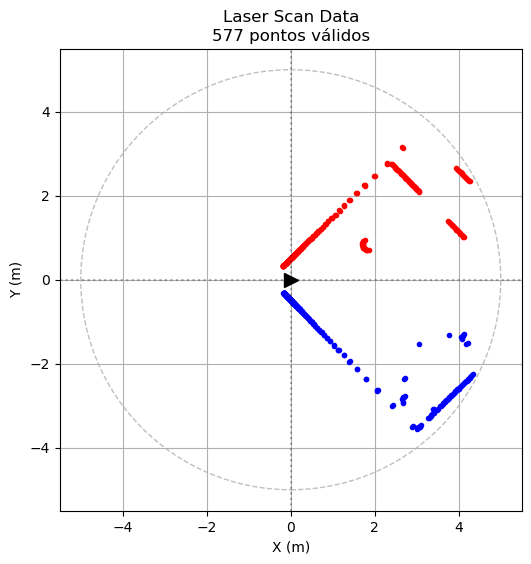

Transformando para o referencial global...
Visualizando dados no referencial global...


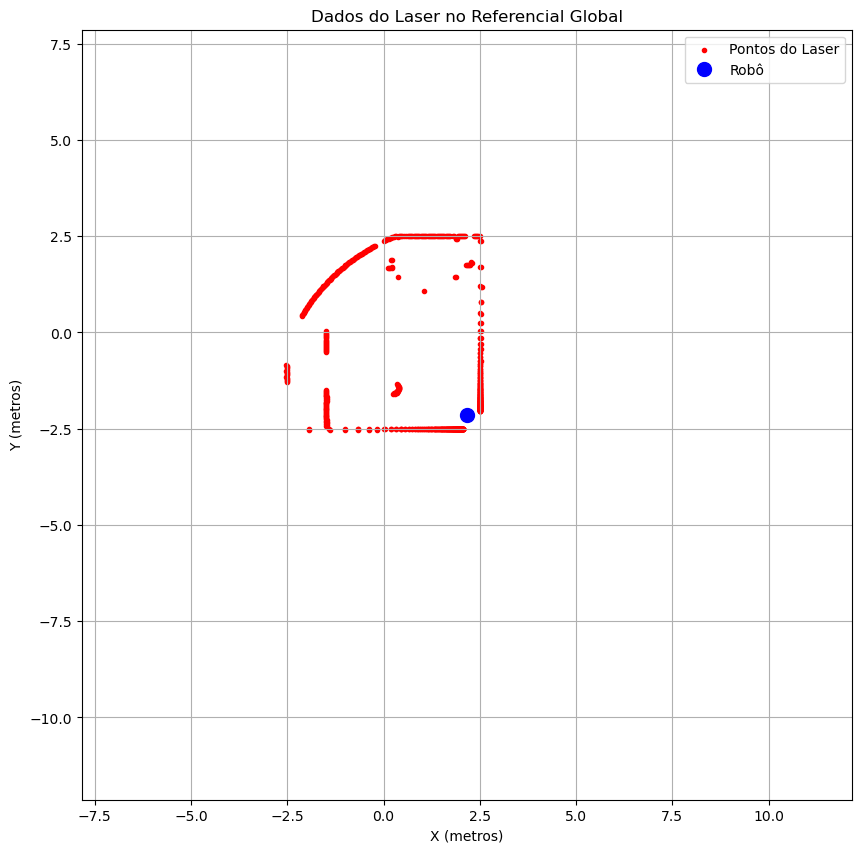


Posição 2 (Após movimento)
----------------------
Movendo o robô para a direita...
Nova posição do robô: [1.899, -1.885, 0.139]
Nova orientação do robô: [0.1°, 0.1°, 136.4°]


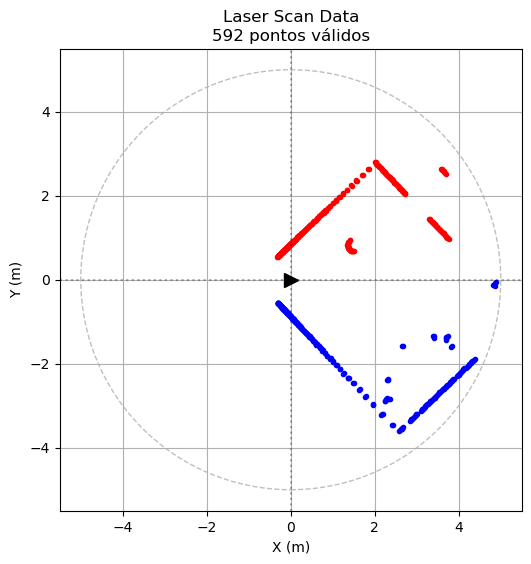

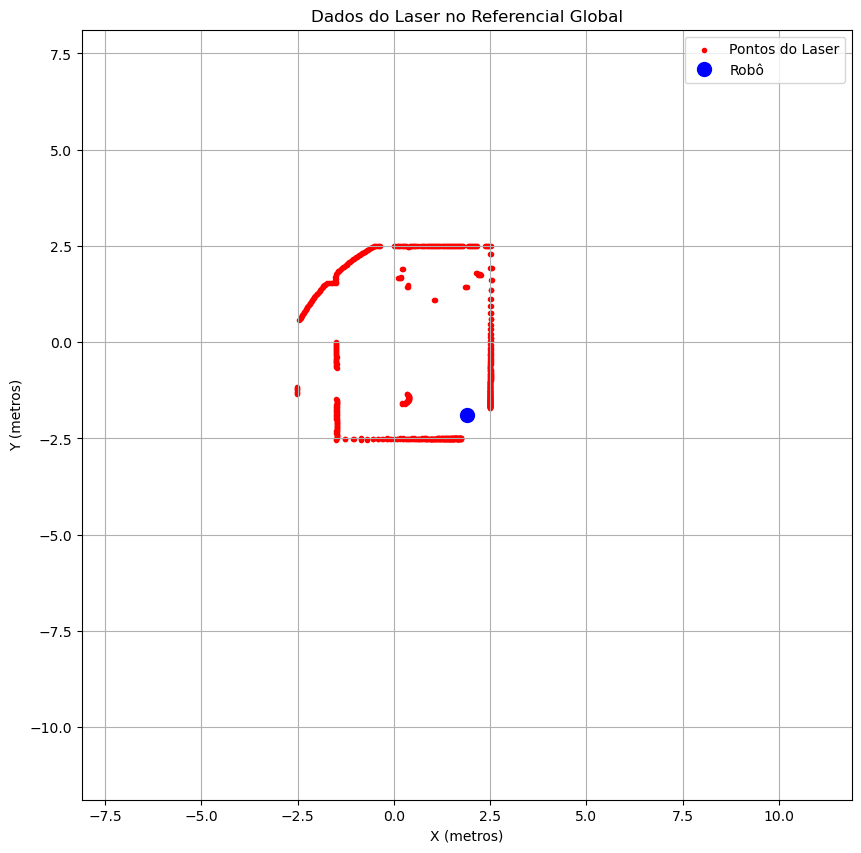


Exercício 5 completado com sucesso!

Finalizando simulação...
Exercício 5 concluído.


In [5]:
# Implementação do Exercício 5: Transformação dos dados do laser para o referencial global

print("Exercício 5: Transformação dos dados do laser para o referencial global")

try:
    # Conectar ao simulador
    print("Conectando ao simulador...")
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Obter handles dos objetos
    print("Obtendo handles dos objetos...")
    robotname = 'PioneerP3DX'
    robot_handle = sim.getObject(f'/{robotname}')
    if robot_handle == -1:
        raise ValueError(f"Robô '{robotname}' não encontrado")

    l_wheel = sim.getObject(f'/{robotname}/leftMotor')
    r_wheel = sim.getObject(f'/{robotname}/rightMotor')
    if l_wheel == -1 or r_wheel == -1:
        raise ValueError("Rodas não encontradas")

    # Criar o sensor Hokuyo
    print("Criando o sensor Hokuyo...")
    hokuyo_path = f"/{robotname}/fastHokuyo"
    hokuyo_obj = sim.getObject(hokuyo_path)
    if hokuyo_obj == -1:
        raise ValueError(f"Objeto '{hokuyo_path}' não encontrado")

    hokuyo_sensor = HokuyoSensorSim(sim, hokuyo_path)
    hokuyo_handle = hokuyo_sensor._base_obj

    # Verificar se a simulação está rodando e parar se necessário
    if sim.getSimulationState() != sim.simulation_stopped:
        print("Parando simulação anterior...")
        sim.stopSimulation()
        time.sleep(1)

    # Dados do Pioneer P3DX
    L = 0.381  # Distância entre rodas (m)
    r = 0.0975  # Raio das rodas (m)

    # Lista para armazenar os resultados das diferentes posições
    positions_results = []

    # Iniciar simulação
    print("\nIniciando simulação...")
    sim.startSimulation()

    # === POSIÇÃO 1: INICIAL ===
    print("\nPosição 1 (Inicial)")

    # Avançar alguns passos para estabilizar
    for _ in range(10):
        sim.step()

    # Obter pose do robô
    robot_pos = sim.getObjectPosition(robot_handle, sim.handle_world)
    robot_orient = sim.getObjectOrientation(robot_handle, sim.handle_world)
    print(f"Posição do robô: [{robot_pos[0]:.3f}, {robot_pos[1]:.3f}, {robot_pos[2]:.3f}]")
    print(f"Orientação do robô: [{np.rad2deg(robot_orient[0]):.1f}°, {np.rad2deg(robot_orient[1]):.1f}°, {np.rad2deg(robot_orient[2]):.1f}°]")

    # Obter dados do laser
    print("Obtendo dados do laser...")
    try:
        initial_laser_data = hokuyo_sensor.getSensorData()
        print(f"Número de pontos do laser: {len(initial_laser_data)}")

        # Visualizar no referencial local do laser
        print("Visualizando dados no referencial local do laser...")
        draw_laser_data(initial_laser_data)

        # Transformar para o referencial global
        print("Transformando para o referencial global...")
        global_points = transform_laser_data_to_global_frame(
            sim, initial_laser_data, robot_handle, hokuyo_handle)

        # Visualizar no referencial global
        print("Visualizando dados no referencial global...")
        plot_laser_data_global(global_points, robot_pos)
    except Exception as e:
        print(f"Erro ao processar dados do laser: {e}")
        raise

    # Armazenar resultados
    positions_results.append({
        'position': 'Inicial',
        'robot_pos': robot_pos,
        'robot_orient': robot_orient,
        'laser_data': initial_laser_data,
        'global_points': global_points
    })

    # === POSIÇÃO 2: APÓS MOVIMENTO ===
    print("\nPosição 2 (Após movimento)")
    print("----------------------")

    # Aplicar movimento (rotação para a direita)
    print("Movendo o robô para a direita...")
    v = 1.5  # Linear velocity (m/s)
    w = -5.5  # Velocidade angular (rad/s) negativa para direita

    # Calcular velocidades das rodas
    wl = v / r - (w * L) / (2 * r)
    wr = v / r + (w * L) / (2 * r)

    # Aplicar velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)

    # Executar rotação
    for _ in range(20):
        sim.step()
        time.sleep(0.02)

    # Parar o robô
    sim.setJointTargetVelocity(l_wheel, 0)
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.step()

    # Estabilizar
    for _ in range(20):
        sim.step()

    # Obter nova pose do robô
    robot_pos = sim.getObjectPosition(robot_handle, sim.handle_world)
    robot_orient = sim.getObjectOrientation(robot_handle, sim.handle_world)
    print(f"Nova posição do robô: [{robot_pos[0]:.3f}, {robot_pos[1]:.3f}, {robot_pos[2]:.3f}]")
    print(f"Nova orientação do robô: [{np.rad2deg(robot_orient[0]):.1f}°, {np.rad2deg(robot_orient[1]):.1f}°, {np.rad2deg(robot_orient[2]):.1f}°]")

    # Obter e transformar dados do laser
    try:
        final_laser_data = hokuyo_sensor.getSensorData()
        global_points = transform_laser_data_to_global_frame(
            sim, final_laser_data, robot_handle, hokuyo_handle)

        # Visualizar dados
        draw_laser_data(final_laser_data)
        plot_laser_data_global(global_points, robot_pos)
    except Exception as e:
        print(f"Erro ao processar dados do laser: {e}")
        raise

    # Armazenar resultados
    positions_results.append({
        'position': 'Após movimento para direita',
        'robot_pos': robot_pos,
        'robot_orient': robot_orient,
        'laser_data': final_laser_data,
        'global_points': global_points
    })

    print("\nExercício 5 completado com sucesso!")

except Exception as e:
    print(f"Erro durante o exercício 5: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Parar a simulação no final
    print("\nFinalizando simulação...")
    sim.stopSimulation()
    print("Exercício 5 concluído.")

## Exercício 6: Navegação Autônoma e Mapeamento Incremental

Neste exercício, vamos:
1. Usar o script básico de navegação para mover o robô de forma autônoma
2. Criar um plot incremental que mostra:
   - O caminho percorrido pelo robô (sequência de posições)
   - Todas as leituras de laser realizadas durante a navegação, combinadas em um único gráfico
3. Todas as informações serão representadas no referencial global

Isso nos permitirá visualizar tanto a trajetória do robô quanto um mapa simplificado do ambiente, construído a partir das leituras acumuladas do sensor laser.

In [6]:
def plot_incremental_map(robot_trajectory, all_laser_points):
    """
    Cria um plot incremental mostrando a trajetória do robô e todos os pontos do laser.

    Args:
        robot_trajectory: Lista de posições do robô [(x, y, z), ...]
        all_laser_points: Lista de arrays de pontos do laser no referencial global
    """
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_title("Mapeamento Incremental - Trajetória do Robô e Pontos do Laser")
    ax.set_xlabel("X (metros)")
    ax.set_ylabel("Y (metros)")

    # Converter trajetória para arrays
    traj_x = [pos[0] for pos in robot_trajectory]
    traj_y = [pos[1] for pos in robot_trajectory]

    # Plotar a trajetória do robô como uma linha tracejada
    ax.plot(traj_x, traj_y, 'b--', linewidth=2, label='Trajetória do Robô')

    # Plotar pontos iniciais e finais da trajetória
    ax.plot(traj_x[0], traj_y[0], 'go', markersize=8, label='Posição Inicial')
    ax.plot(traj_x[-1], traj_y[-1], 'ro', markersize=8, label='Posição Final')

    # Plotar todos os pontos do laser (mapa combinado)
    all_points = np.vstack(all_laser_points)
    ax.scatter(all_points[:, 0], all_points[:, 1], c='r', marker='.', s=2, alpha=0.6, label='Leituras do Laser')

    ax.grid(True)
    ax.legend()

    # Ajustar os limites para cobrir toda a área
    min_x = min(np.min(all_points[:, 0]), np.min(traj_x)) - 1
    max_x = max(np.max(all_points[:, 0]), np.max(traj_x)) + 1
    min_y = min(np.min(all_points[:, 1]), np.min(traj_y)) - 1
    max_y = max(np.max(all_points[:, 1]), np.max(traj_y)) + 1

    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])

    plt.show()

    return fig, ax

Exercício 6: Navegação Autônoma e Mapeamento Incremental
Conectando ao simulador...
Obtendo handles dos objetos...
Criando o sensor Hokuyo...
Iniciando simulação...
Estabilizando a simulação...

Iniciando navegação autônoma com mapeamento incremental...
Tempo de simulação: 24.95/25.00 s

Navegação completa.
Trajetória registrada com 500 pontos
Dados de laser coletados: 500 conjuntos

Gerando mapa incremental...


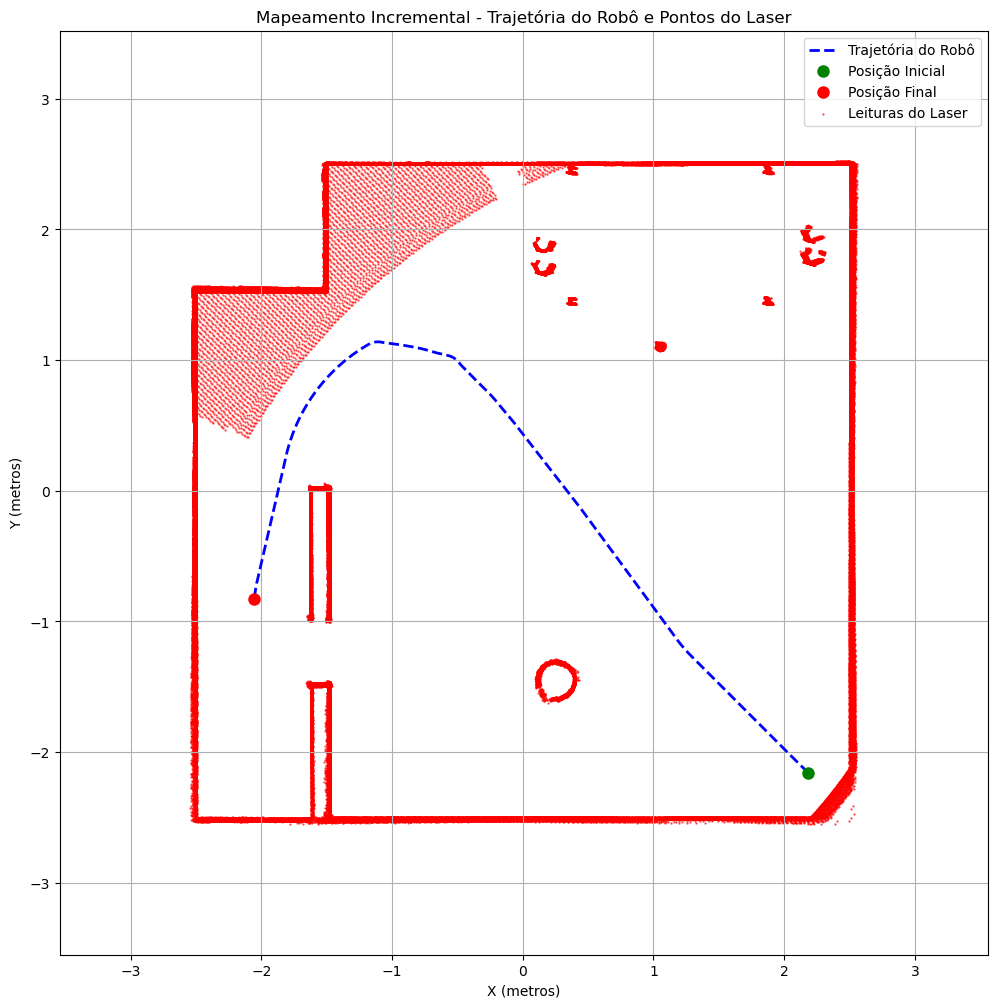

Finalizando simulação...
Exercício 6 concluído.


In [7]:
# Implementação do Exercício 6: Navegação Autônoma e Mapeamento Incremental

print("Exercício 6: Navegação Autônoma e Mapeamento Incremental")

# Configurações
SIMULATION_TIME = 25  # Segundos de simulação
SAMPLE_FREQ = 20      # Hz (frequência de amostragem)

try:
    # Conectar ao simulador
    print("Conectando ao simulador...")
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Obter handles dos objetos
    print("Obtendo handles dos objetos...")
    robotname = 'PioneerP3DX'
    robot_handle = sim.getObject(f'/{robotname}')
    if robot_handle == -1:
        raise ValueError(f"Robô '{robotname}' não encontrado")

    l_wheel = sim.getObject(f'/{robotname}/leftMotor')
    r_wheel = sim.getObject(f'/{robotname}/rightMotor')
    if l_wheel == -1 or r_wheel == -1:
        raise ValueError("Rodas não encontradas")

    # Criar o sensor Hokuyo
    print("Criando o sensor Hokuyo...")
    hokuyo_path = f"/{robotname}/fastHokuyo"
    hokuyo_obj = sim.getObject(hokuyo_path)
    if hokuyo_obj == -1:
        raise ValueError(f"Objeto '{hokuyo_path}' não encontrado")

    hokuyo_sensor = HokuyoSensorSim(sim, hokuyo_path)
    hokuyo_handle = hokuyo_sensor._base_obj

    # Verificar se a simulação está rodando e parar se necessário
    if sim.getSimulationState() != sim.simulation_stopped:
        print("Parando simulação anterior...")
        sim.stopSimulation()
        time.sleep(1)

    # Dados do Pioneer P3DX
    L = 0.381  # Distância entre rodas (m)
    r = 0.0975  # Raio das rodas (m)

    # Listas para armazenar o histórico da trajetória e das leituras do laser
    robot_trajectory = []
    all_laser_points = []

    # Iniciar simulação
    print("Iniciando simulação...")
    sim.startSimulation()

    # Estabilizar a simulação
    print("Estabilizando a simulação...")
    for _ in range(5):
        sim.step()

    print("\nIniciando navegação autônoma com mapeamento incremental...")

    # Configuração do loop de simulação
    dt = 1.0 / SAMPLE_FREQ
    num_samples = int(SIMULATION_TIME * SAMPLE_FREQ)

    # Executar loop de navegação autônoma
    for i in range(num_samples):
        current_time = i * dt
        print(f"\rTempo de simulação: {current_time:.2f}/{SIMULATION_TIME:.2f} s", end="")

        # Obter posição atual do robô
        robot_pos = sim.getObjectPosition(robot_handle, sim.handle_world)

        # Adicionar posição à trajetória
        robot_trajectory.append(robot_pos)

        try:
            # Obter e transformar dados do laser
            laser_data = hokuyo_sensor.getSensorData()
            global_points = transform_laser_data_to_global_frame(
                sim, laser_data, robot_handle, hokuyo_handle)

            # Adicionar pontos à lista de pontos do laser
            all_laser_points.append(global_points)

            # Algoritmo de navegação simplificado
            # Identificar pontos de interesse no laser
            frente_idx = min(int(len(laser_data) / 2), len(laser_data) - 1)
            direita_idx = min(int(len(laser_data) * 1 / 4), len(laser_data) - 1)
            esquerda_idx = min(int(len(laser_data) * 3 / 4), len(laser_data) - 1)

            # Obter distâncias em direções específicas
            dist_frente = laser_data[frente_idx, 1] if frente_idx < len(laser_data) else 5.0
            dist_direita = laser_data[direita_idx, 1] if direita_idx < len(laser_data) else 5.0
            dist_esquerda = laser_data[esquerda_idx, 1] if esquerda_idx < len(laser_data) else 5.0

            # Lógica de navegação com desvio de obstáculos
            threshold_dist = 1.5  # distância limiar para detecção de obstáculo (m)

            if dist_frente > threshold_dist:
                # Caminho livre à frente
                v = 0.3
                w = 0

                # Ajuste fino de direção se há obstáculo próximo
                if dist_direita < threshold_dist and dist_esquerda > threshold_dist:
                    # Obstáculo à direita, ajuste suave para a esquerda
                    w = 0.2
                elif dist_esquerda < threshold_dist and dist_direita > threshold_dist:
                    # Obstáculo à esquerda, ajuste suave para a direita
                    w = -0.2
            elif dist_direita > dist_esquerda:
                # Obstáculo à frente, mas espaço à direita
                v = 0.1
                w = -0.5  # girar à direita
            else:
                # Obstáculo à frente, mas espaço à esquerda
                v = 0.1
                w = 0.5  # girar à esquerda

        except Exception as e:
            print(f"\nErro ao processar dados do laser: {e}")
            # Se houver erro na leitura do sensor, desacelerar o robô
            v = 0.05
            w = 0.0
            print("Desacelerando o robô devido a erro na leitura do sensor")

        # Converter para velocidades das rodas usando o modelo cinemático
        wl = v / r - (w * L) / (2 * r)
        wr = v / r + (w * L) / (2 * r)

        # Enviar comandos para as rodas
        sim.setJointTargetVelocity(l_wheel, wl)
        sim.setJointTargetVelocity(r_wheel, wr)

        # Avançar a simulação
        sim.step()
        time.sleep(dt)

    # Parar o robô no final
    sim.setJointTargetVelocity(l_wheel, 0)
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.step()

    print("\n\nNavegação completa.")
    print(f"Trajetória registrada com {len(robot_trajectory)} pontos")
    print(f"Dados de laser coletados: {len(all_laser_points)} conjuntos")

    # Gerar o mapa incremental
    if all_laser_points:
        print("\nGerando mapa incremental...")
        plot_incremental_map(robot_trajectory, all_laser_points)
    else:
        print("\nAviso: Nenhum dado de laser válido foi coletado para gerar o mapa")

except Exception as e:
    print(f"\nErro durante o exercício 6: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Parar a simulação
    print("Finalizando simulação...")
    sim.stopSimulation()
    print("Exercício 6 concluído.")

## Conclusão

Neste trabalho prático, foi implementado:

1. **Exercício 5:**
   - Definimos as matrizes de transformação necessárias para converter dados do sensor laser para o referencial global;
   - Implementamos a visualização dos pontos do laser em diferentes posições do robô;
   - Validamos que as transformações mantêm a consistência dos dados entre diferentes poses do robô...

2. **Exercício 6:**
   - Implementamos um algoritmo de navegação autônoma com desvio de obstáculos;
   - Criamos um mecanismo de mapeamento incremental que combina todas as leituras do laser;
   - Visualizamos tanto a trajetória do robô quanto o mapa resultante em um único gráfico...



## Desafios Enfrentados

1. **CoppeliaSim:**
   - Criacao da simulacao: error com objetos quebrados e estrutura pequena para colisao do laser;
   - O acesso aos sensores de visão requer um conhecimento específico da API do CoppeliaSim, devido a isso reutilizei quase por completo o codigo fornecido pelo professor.
